# Classify names with character n-grams

In [1]:
from argparse import Namespace
import os
os.environ['OMP_NUM_THREADS'] = '4' 

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook

%matplotlib inline

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (14, 6)

## Overview of Data/Task
- Data compiled by [Sean Robertson](https://github.com/spro)
- Predict nationality from names.
- Data consist of 20074 names, 18 categories. 
- Russian names are dominant (skewing labels)
  - We downsample russian names to minimize the skew. Checkout the RNN tutorial for a different approach to handle label bias.

```
    2750 names_test.csv
   10994 names_train.csv
```

### Args for this example

In [2]:
args = Namespace(
    surname_csv="../data/surnames.csv",
    model_filename="names_mlp_model.pth",
    cuda=False,
    num_epochs=100
)


# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False

print("Using CUDA: {}".format(args.cuda))

args.device = torch.device("cuda" if args.cuda else "cpu")
args.device

Using CUDA: False


device(type='cpu')

## Load names

In [3]:
name_data = pd.read_csv(args.surname_csv)

## Class Breakdown

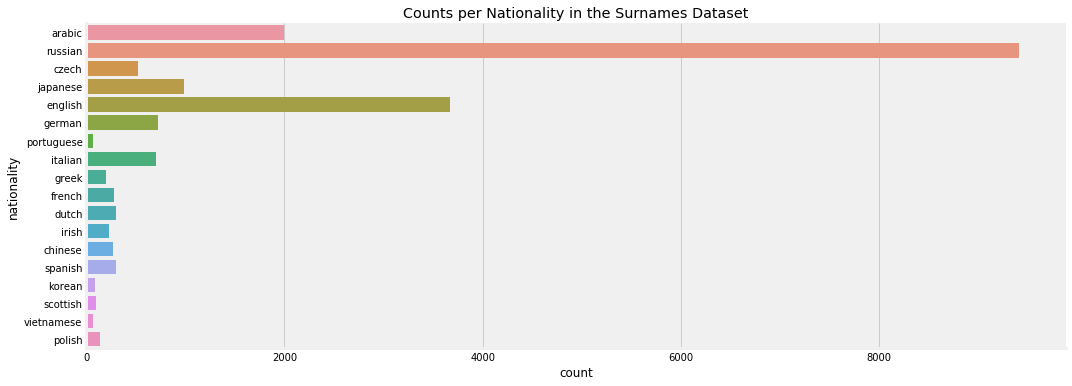

In [4]:
sns.catplot(data=name_data, y='nationality', 
               kind='count', height=5, aspect=3);
plt.title("Counts per Nationality in the Surnames Dataset");

In [5]:
def fix_imbalance(df, seed=0):
    np.random.seed(seed)
    median = df.groupby('nationality').agg('count').split.median()
    for nationality in df.nationality.unique():
        
        df_main = df[df.nationality != nationality]
        df_sub = df[df.nationality == nationality].reset_index(drop=True)
        if len(df_sub) > median:
            size = min(len(df_sub), int(median+0.05*len(df_sub)))
            indices = np.random.choice(np.arange(len(df_sub)), 
                                       size=size, 
                                       replace=False)
            df_sub = df_sub.iloc[indices]
        df = pd.concat([df_main, df_sub]).reset_index(drop=True)
    return df

In [6]:
_name_data = name_data

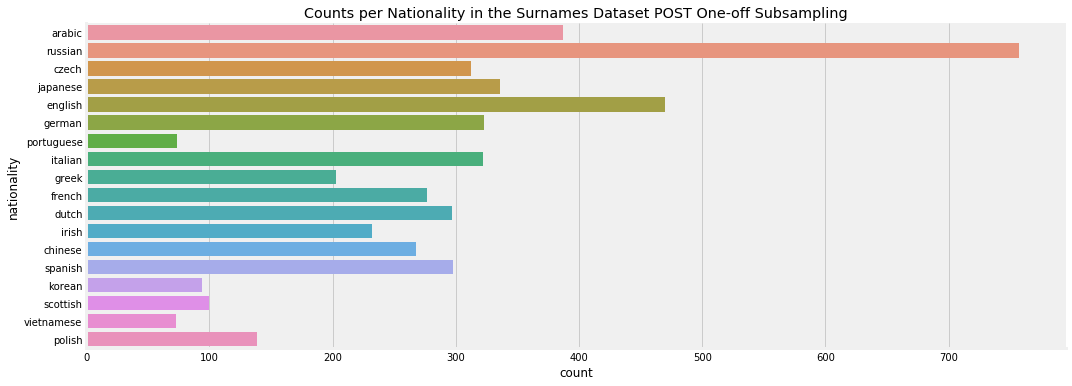

In [7]:
name_data = fix_imbalance(_name_data)
sns.catplot(data=name_data, y='nationality', 
               kind='count', height=5, aspect=3);
plt.title("Counts per Nationality in the Surnames Dataset POST One-off Subsampling");

# Feature Engineering

## 1. Lowercase

In [8]:
name_data['features'] = name_data['surname'].apply(lambda x: x.lower())
name_data.head()

,Unnamed: 0,nationality,split,surname,features
0,12210,arabic,train,Tannous,tannous
1,14310,arabic,train,Asfour,asfour
2,12649,arabic,train,Attia,attia
3,10941,arabic,train,Baba,baba
4,10184,arabic,train,Asghar,asghar


## 2. Add begin and end tokens


In [9]:
def add_begin_end_tokens(name):
    # return "^{}$".format(name)
    begin_token_marker = "^"
    end_token_marker = '$'
    return "".join((begin_token_marker, name, end_token_marker))

In [10]:
name_data['features'] = name_data['features'].apply(add_begin_end_tokens)
name_data.head()

,Unnamed: 0,nationality,split,surname,features
0,12210,arabic,train,Tannous,^tannous$
1,14310,arabic,train,Asfour,^asfour$
2,12649,arabic,train,Attia,^attia$
3,10941,arabic,train,Baba,^baba$
4,10184,arabic,train,Asghar,^asghar$


## 3. Extract Character N-grams

In [11]:
def extract_n_grams(tokens, n):
    '''
    param tokens: tokenized text
    return: list of n grams
    '''
    return [tokens[i:i + n] for i in range(len(tokens) - n + 1)]

In [12]:
# use trigrams
name_data['features'] = name_data['features'].apply(lambda x: extract_n_grams(x, 3))
name_data.head()

,Unnamed: 0,nationality,split,surname,features
0,12210,arabic,train,Tannous,"[^ta, tan, ann, nno, nou, ous, us$]"
1,14310,arabic,train,Asfour,"[^as, asf, sfo, fou, our, ur$]"
2,12649,arabic,train,Attia,"[^at, att, tti, tia, ia$]"
3,10941,arabic,train,Baba,"[^ba, bab, aba, ba$]"
4,10184,arabic,train,Asghar,"[^as, asg, sgh, gha, har, ar$]"


## 4. Build vocabulary

In [13]:
vocabulary  = set()
for name in name_data['features'].values:
    [vocabulary.add(ngram) for ngram in name]        

In [14]:
maxlen = max(name_data['features'].apply(len))
maxlen

17

## 5. Map n-grams to indices

In [15]:
ngram_to_index = {ngram:i for i, ngram in enumerate(sorted(vocabulary), 1)}

In [16]:
def n_grams_to_indices(n_grams):
    unknown_index = len(ngram_to_index) + 1
    return [ngram_to_index.get(ngram, unknown_index) for ngram in n_grams]  

In [17]:
n_grams_to_indices(['^ha', 'had', 'ada', 'dad', 'ad$'])

[161, 1718, 415, 1000, 414]

## 6. Pad indices

In [18]:
def pad_indices(indices, maxlen=20):
    padded = np.zeros(maxlen, dtype=np.int64)
    for i, index in enumerate(indices):
        padded[i] = index
    return padded 

In [19]:
test_name = n_grams_to_indices(['^ha', 'had', 'ada', 'dad', 'ad$'])
pad_indices(test_name, 20)

array([ 161, 1718,  415, 1000,  414,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0])

## 7. Encode class labels as numbers

In [20]:
label_to_number = {y: i for i, y in enumerate(sorted(set(name_data['nationality'])))}
number_to_label = {i: y for i, y in enumerate(sorted(set(name_data['nationality'])))}

In [21]:
label_to_number

{'arabic': 0,
 'chinese': 1,
 'czech': 2,
 'dutch': 3,
 'english': 4,
 'french': 5,
 'german': 6,
 'greek': 7,
 'irish': 8,
 'italian': 9,
 'japanese': 10,
 'korean': 11,
 'polish': 12,
 'portuguese': 13,
 'russian': 14,
 'scottish': 15,
 'spanish': 16,
 'vietnamese': 17}

## 8. Consolidate data preperation pipeline

In [22]:
def extract_name_features(name, n_grams=3):
    """
    Applies feature extraction pipeline to name
    """
    features = name.lower()
    features = add_begin_end_tokens(features)
    features = extract_n_grams(features, n_grams)
    features = n_grams_to_indices(features)
    features = pad_indices(features)
    features = torch.from_numpy(features).long()
    return features

In [23]:
extract_name_features('Brian')

tensor([  92,  832, 3599, 1905,  558,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

## Create PyTorch Dataset

In [24]:
class VectorizedSurnames(Dataset):
    """Name Classification dataset"""

    def __init__(self, data):
        '''
        Args:
            data (pandas.DataFrame)
        '''
        self.data = data
        self.x_surnames = self.data['surname'].apply(lambda x: extract_name_features(x, 3))
        self.y_nationalities = self.data['nationality'].apply(lambda x: label_to_number[x])

    @classmethod
    def from_file(cls, filename, split='train', apply_fix=True):
        df = pd.read_csv(filename).dropna()
        df = df[df.split == split]
        if apply_fix:
            df = fix_imbalance(df)
        return cls(df)
    
    def __len__(self):
        return len(self.x_surnames)

    def __getitem__(self, index):
        return {'x_surnames': self.x_surnames.iloc[index],
                'y_nationalities': self.y_nationalities.iloc[index]}

In [25]:
train_dataset = VectorizedSurnames.from_file(args.surname_csv, split='train', apply_fix=True)
val_dataset = VectorizedSurnames.from_file(args.surname_csv, split='val', apply_fix=False)

In [26]:
train_dataset[5]

{'x_surnames': tensor([ 134, 1411, 3929, 3788,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]),
 'y_nationalities': 0}

In [27]:
# index first into the __getitem__ above and then into the resulting dictionary
train_dataset[0]['x_surnames'].type(), train_dataset[0]['y_nationalities'].dtype

('torch.LongTensor', dtype('int64'))

In [28]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)

## Define MLP

In [30]:
class MLP(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_size, maxlen, dropout_p=0.5):
        super(MLP, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.fc1 = nn.Linear(embedding_dim * maxlen, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_size)
        self._dropout_p = dropout_p

    def forward(self, x, apply_softmax=False):
        x = self.embeddings(x).view(-1, (embedding_dim * maxlen))
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=self._dropout_p)
        x = self.fc2(x)
        if apply_softmax:
            x = F.softmax(x, dim=1)
        return x

In [32]:
vocab_size = len(vocabulary) + 2 # one for unknown index
embedding_dim = 100 # hidden dim.
hidden_dim = 200
output_size = len(label_to_number) # number of classes
maxlen = 20

classifier = MLP(vocab_size, embedding_dim, hidden_dim, output_size, maxlen)

## Train

In [33]:
def compute_accuracy(y_pred, y_target):
    _, y_pred_indices = y_pred.max(dim=1)
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

In [34]:
classifier = classifier.to(args.device)

optimizer = optim.Adam(classifier.parameters())
criterion = nn.CrossEntropyLoss()

In [37]:
classifier = classifier.to(args.device)

optimizer = optim.Adam(classifier.parameters())
criterion = nn.CrossEntropyLoss()

train_loss_history = []
train_accuracy_history = []
val_loss_history = []
val_accuracy_history = []


epoch_bar = tqdm_notebook(desc='epochs', total=args.num_epochs)

try:
    for _ in range(args.num_epochs):
        per_epoch_train_losses = []
        per_epoch_train_accuracy = []
        per_epoch_val_losses = []
        per_epoch_val_accuracy = []
        
        classifier.train()
        
        for batch in train_dataloader:
            # Step 1: clear the gradients 
            optimizer.zero_grad()
        
            # Step 2: apply the model to the data
            x_surnames = batch['x_surnames'].to(args.device)
            y_nationalities = batch['y_nationalities'].to(args.device)
        
            y_prediction = classifier(x_surnames)
        
            # Step 3: compute the loss and propagate the gradients
            
            loss = criterion(y_prediction, y_nationalities)
            loss.backward()
        
            # Step 4; have optimizer update the model weights
            optimizer.step()
            
            # bonus steps:  bookkeeping
            
            per_epoch_train_losses.append(loss.item())
            
            accuracy = compute_accuracy(y_prediction, y_nationalities)
            per_epoch_train_accuracy.append(accuracy)
        
        classifier.eval()
        for batch in val_dataloader:
            # Step 2: apply the model to the data
            x_surnames = batch['x_surnames'].to(args.device)
            y_nationalities = batch['y_nationalities'].to(args.device)

            y_prediction = classifier(x_surnames)

            # Step 3: compute the loss and propagate the gradients
            
            loss = criterion(y_prediction, y_nationalities)

            # bonus steps:  bookkeeping
            
            per_epoch_val_losses.append(loss.item())
            
            accuracy = compute_accuracy(y_prediction, y_nationalities)
            per_epoch_val_accuracy.append(accuracy)
            


        train_loss_history.append(np.mean(per_epoch_train_losses))
        train_accuracy_history.append(np.mean(per_epoch_train_accuracy))
        val_loss_history.append(np.mean(per_epoch_val_losses))
        val_accuracy_history.append(np.mean(per_epoch_val_accuracy))
        epoch_bar.set_postfix(train_loss=train_loss_history[-1], train_acc=train_accuracy_history[-1], 
                              val_loss=val_loss_history[-1], val_acc=val_accuracy_history[-1])
        epoch_bar.update()
except KeyboardInterrupt:
    print("...")

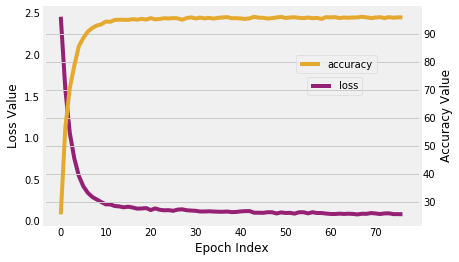

In [39]:
_, ax = plt.subplots(1, 1)
ax.plot(loss_history, color='#942174', label='loss')
plt.legend(bbox_to_anchor=(0.86, 0.7))
ax.grid(False)
ax.set_xlabel("Epoch Index")
ax.set_ylabel("Loss Value")
ax2 = plt.twinx()
ax2.set_ylabel("Accuracy Value")
ax2.plot(accuracy_history, color='#e5a930', label='accuracy')
plt.legend(bbox_to_anchor=(0.9, 0.8))

## save model

In [44]:
torch.save(classifier.state_dict(), args.model_filename)

## load model

In [38]:
classifier.load_state_dict(torch.load(args.model_filename))

## Evaluate on test set

In [38]:
from sklearn.metrics import confusion_matrix, accuracy_score

test_dataset = VectorizedSurnames.from_file(args.surname_csv, split='test')
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=0)

classifier = classifier.to(args.device)

classifier.eval()

ground_truth = []
predictions = []
for batch in test_dataloader:
    x_surnames = batch['x_surnames'].to(args.device)
    y_nationalities = batch['y_nationalities'].to(args.device)

    
    outputs = classifier(x_surnames)
    
    y_pred_probabilities, y_pred_indices = torch.max(outputs, dim=1)
    
    ground_truth.append(y_nationalities.detach().cpu().numpy())
    predictions.append(y_pred_indices.detach().cpu().squeeze().numpy())
    
ground_truth = np.concatenate(ground_truth)
predictions = np.concatenate(predictions)

print(accuracy_score(ground_truth, predictions)) 

0.5475728155339806


Text(0.5, 1, 'Counts per Nationality in the Surnames Test Set')

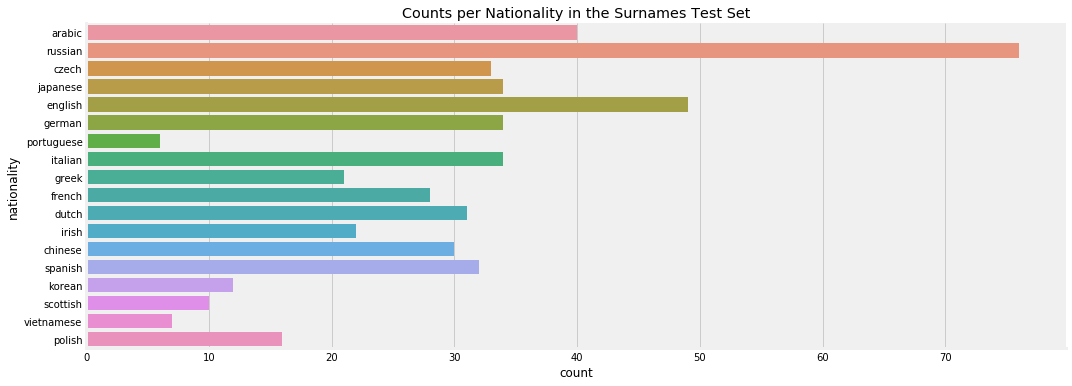

In [40]:
sns.catplot(data=test_dataset.data, y='nationality', 
               kind='count', height=5, aspect=3);
plt.title("Counts per Nationality in the Surnames Test Set")

In [41]:
labels = test_dataset.data.nationality.values

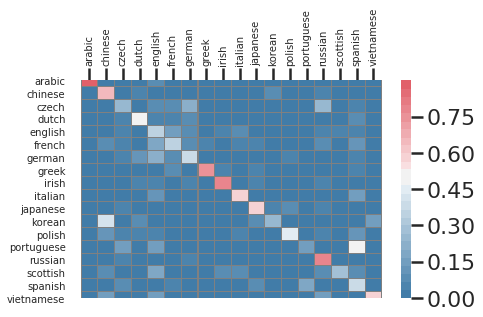

In [42]:
sns.set_style('white')
sns.set_context('poster')
labels = [number_to_label[i] for i in range(len(number_to_label))]
cm = confusion_matrix(ground_truth, predictions).astype(np.float32)
cm /= cm.sum(axis=1, keepdims=True)
g = sns.heatmap(cm, 
                cmap=sns.diverging_palette(240, 10, n=30), 
                center=0.5,
                linewidths=0.01, 
                linecolor='gray');
g.xaxis.tick_top()
g.set_xticks([0.5 + i for i in range(len(labels))])
g.set_yticks([0.5 + i for i in range(len(labels))])
g.set_xticklabels(labels, rotation=90, size=10);
g.set_yticklabels(labels, rotation=0, size=10);


## Exercise: run your name through the model

In [43]:
name = extract_name_features('mcmahan')
name = name.view(1,-1) # reshape because model expects a batch

prediction = classifier(name.to(args.device), apply_softmax=True)
top_pred, index = torch.max(prediction, dim=1)
number_to_label[index[0].item()]

'irish'